# Overview of Dataset

The dataset appears to be designed for analyzing the effectiveness of an advertising campaign. It includes user-level data capturing interactions with ads, user group categorizations, and conversion outcomes. With over `588,000` entries, it provides a large sample size suitable for conducting meaningful analyses, such as `A/B testing`, `behavioral segmentation`, and `predictive modeling`.

##### **Key Features**

- **user id**: A unique identifier for each user, ensuring that individual-level behavior can be tracked.

- **test group**: Categorical data indicating the group the user belongs to, such as an "ad" or "psa" group in an A/B test setup.

- **converted**: A binary outcome indicating whether the user converted (e.g., made a purchase or signed up).

- **total ads**: A numerical measure of the total ads shown to the user, providing insights into ad exposure.

- **most ads day**: The day of the week when the user was most engaged with ads, helpful for understanding temporal patterns.

- **most ads hour**: The hour of the day when the user was most engaged, allowing analysis of peak engagement times.

##### **Potential Use Cases**

1. **A/B Testing**: By analyzing the test group variable, comparisons can be made between groups to determine which ad strategy or content performs better.

2. **Behavioral Insights**: Examining most ads day and most ads hour can reveal optimal times for ad placement.

3. **Ad Exposure Analysis**: Understanding the relationship between total ads and converted can guide ad frequency optimization.

4. **Conversion Analysis**: Investigating what factors contribute to user conversions and how different test groups perform.

In [20]:
#import liraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats

In [21]:
df = pd.read_csv('marketing_AB.csv')

In [22]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


# Statistical Info

In [23]:
df.shape

(588101, 7)

>  With over half a million entries, it provides sufficient data for statistically significant insights.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


> Well-structured Data: The dataset contains a mix of numerical, categorical, and binary variables, allowing for diverse analysis techniques.

> No Missing Values: The absence of missing data ensures robustness in analysis without the need for imputation.

In [25]:
df.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


# Exploratory Data Analysis

In [26]:
# make a variable named num_cols
num_cols = df.select_dtypes(include=['number'])

In [27]:
# make a variable named cat_cols
cat_cols = df.select_dtypes(include=['object'])

In [28]:
# prinnt the count and the percentage of unique values in each column of cat_cols.
for col in cat_cols:
    count = cat_cols[col].value_counts()
    perc = count/len(cat_cols[col]) *100
    print(f"Count and percentage of values in {col}: {count}")
    print(f"Percentage of unique values in {col}: {perc}")
    print('-----------------------------------')

Count and percentage of values in test group: test group
ad     564577
psa     23524
Name: count, dtype: int64
Percentage of unique values in test group: test group
ad     96.000007
psa     3.999993
Name: count, dtype: float64
-----------------------------------
Count and percentage of values in most ads day: most ads day
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: count, dtype: int64
Percentage of unique values in most ads day: most ads day
Friday       15.746955
Monday       14.805790
Sunday       14.519785
Thursday     14.110161
Saturday     13.885370
Wednesday    13.757501
Tuesday      13.174438
Name: count, dtype: float64
-----------------------------------


In [29]:
cont_var = ['total ads', 'most ads hour']

In [30]:
from scipy.stats import t, sem # t-distribution, standard error of the mean

In [31]:
#Concatenating Descriptive Statistics
concatenated_series = pd.concat([
    df[cont_var].describe().T,
    df[cont_var].skew().rename('skewness'),
    df[cont_var].kurt().rename('kurtosis')
], axis=1)

#confidence interval
for var in cont_var:
    values = df[var].dropna()
    mean = values.mean()
    std_err = sem(values)
    lower, upper = t.interval(0.95, len(values)-1, loc=mean, scale=std_err)


    concatenated_series.loc[var, 'lower_ci'] = lower
    concatenated_series.loc[var, 'upper_ci'] = upper

concatenated_series

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,lower_ci,upper_ci
total ads,588101.0,24.820876,43.715181,1.0,4.0,13.0,27.0,2065.0,7.433113,109.917983,24.709150,24.932602
most ads hour,588101.0,14.469061,4.834634,0.0,11.0,14.0,18.0,23.0,-0.336972,0.103237,14.456704,14.481417


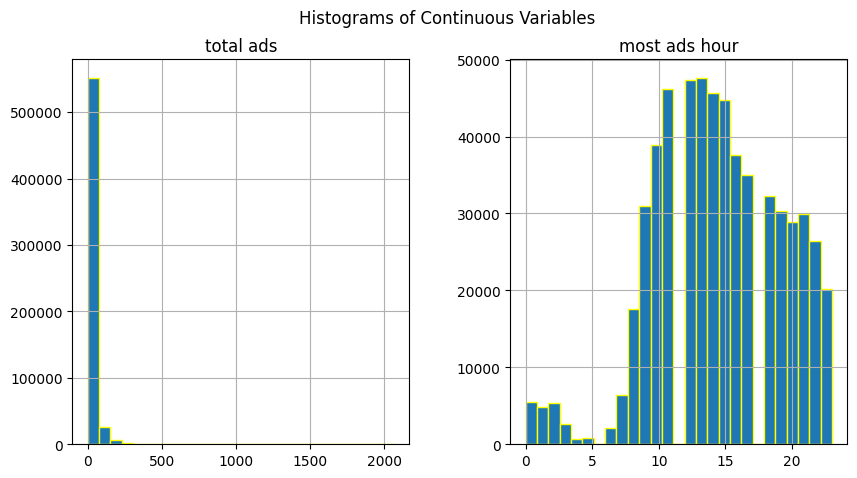

In [32]:
# Plot histograms for each continuous variable
df[cont_var].hist(bins=27, edgecolor='yellow', figsize=(10, 5))

plt.suptitle('Histograms of Continuous Variables')
plt.show()

## Conversion Rate Analysis

In [33]:
import scipy.stats as stats
from scipy.stats import ttest_ind

In [34]:
# By analyzing the test group variable, make comparisons between groups to determine which ad strategy performs better.
# Group data by 'test group' and calculate conversion rates

# Convert boolean 'converted' column to integers
df['converted'] = df['converted'].astype(int)

conversion_rates = df.groupby('test group')['converted'].mean()
print(conversion_rates)

# perform a t-test to determine if the difference in conversion rates is statistically significant.
group_ad = df[df['test group'] == 'ad']['converted']
group_psa = df[df['test group'] == 'psa']['converted']

t_stat, p_val = ttest_ind(group_ad, group_psa)
print(f'T-statistic: {t_stat}, p-value: {p_val}')

#significance level
alpha = 0.05

if p_val < alpha:
    print('There is statistically significant difference in conversion rates between the two groups')
    if conversion_rates['ad'] > conversion_rates['psa']:
        print('The ad strategy is more effective')
    else:
        print('The psa strategy is more effective')
else:
    print('There is no statistically significant difference in conversion rates between the two groups')

test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64
T-statistic: 7.37040597428566, p-value: 1.7033052627831264e-13
There is statistically significant difference in conversion rates between the two groups
The ad strategy is more effective


> The ad strategy empower users to buy the product than 'psa' strategy

In [35]:
# perform the chi-square test to determine the relationship between the test group and conversion rate
# make a contingency table
contingency_table = pd.crosstab(df['converted'], df['test group'])
contingency_table

test group,ad,psa
converted,,
0,550154,23104
1,14423,420


`Null Hypothesis:`There is no significant association between the two variables.

`Alternate Hypothesis:` There is a significant association between the two variables.

In [36]:
from scipy.stats import chi2_contingency

In [37]:
# perform chi2 test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"chi2: {chi2}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}")


chi2: 54.005823883685245
p-value: 1.9989623063390075e-13
degrees of freedom: 1


### Compare the total number of advertisement of `ads` group and `psa` group

In [38]:
# make groups
total_ads = df[df['test group']== 'ad']['total ads'].mean()
total_psa = df[df['test group']== 'psa']['total ads'].mean()

print(f'The average number of ads shown to the ad group is {total_ads}')
print(f'The average number of ads shown to the psa group is {total_psa}')

The average number of ads shown to the ad group is 24.823365103431417
The average number of ads shown to the psa group is 24.761137561639178


### Group data by 'most ads day' and calculate conversion rates

In [39]:
conversion_rates_by_day = df.groupby(['most ads day', 'test group'])['converted'].mean().unstack()
conversion_rates_by_day

test group,ad,psa
most ads day,,
Friday,0.022465,0.016303
Monday,0.033241,0.022559
Saturday,0.021307,0.013996
Sunday,0.024620,0.020595
Thursday,0.021637,0.020230
Tuesday,0.030440,0.014448
Wednesday,0.025356,0.015759


###  Perform t-tests for each day

In [40]:
for day in df['most ads day'].unique():
    group_ad_day = df[(df['test group'] == 'ad') & (df['most ads day'] == day)]['converted']
    group_psa_day = df[(df['test group']== 'psa') & (df['most ads day'] == day)]['converted']

    if len(group_ad_day) > 0 and len(group_psa_day) > 0:
        t_stat, p_val = ttest_ind(group_ad_day, group_psa_day)
        print(f'For {day}, t-statistic: {t_stat}, p-value: {p_val}')

For Monday, t-statistic: 3.4767998173189745, p-value: 0.0005076838310420105
For Tuesday, t-statistic: 4.9725001795688915, p-value: 6.623580376546489e-07
For Friday, t-statistic: 2.5250884891161647, p-value: 0.011568571026075112
For Saturday, t-statistic: 2.6745960256483388, p-value: 0.007483424454519301
For Wednesday, t-statistic: 3.556325296980843, p-value: 0.0003762929908183531
For Sunday, t-statistic: 1.4145989240334367, p-value: 0.15718977081077093
For Thursday, t-statistic: 0.5906506740406489, p-value: 0.5547561128146212


This code is running a separate t-test for each day to see if there's a statistically significant difference in conversion rates between the 'ad' and 'psa' groups on that specific day. The p-value is the key indicator: a low p-value (typically below 0.05) suggests a significant difference in conversion rates between the two groups on that day.

### The Chi-Squared test for independence on the contingency table

In [41]:
from scipy.stats import chi2_contingency

In [42]:
#make the contingency table
contingency_table = pd.crosstab(df['converted'], df['most ads day'])
contingency_table

most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
0,90551,84216,79941,83301,81192,75167,78890
1,2057,2857,1719,2090,1790,2312,2018


`Null Hypothesis:`There is no significant association between the two variables.

`Alternate Hypothesis:` There is a significant association between the two variables.

In [43]:
# perform chi2 test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"chi2: {chi2}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}")

chi2: 410.0478857936585
p-value: 1.932184379244731e-85
degrees of freedom: 6


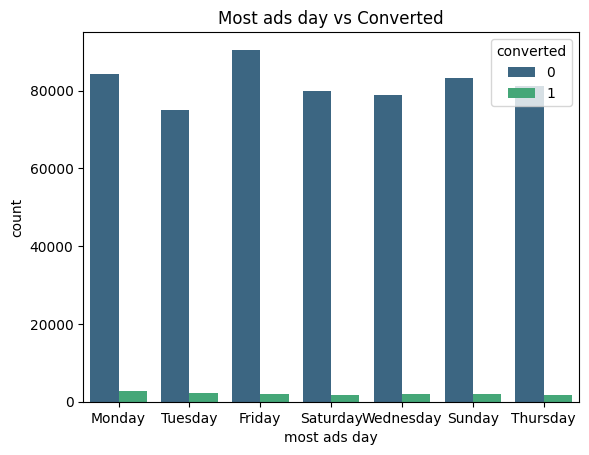

In [44]:
# visualize the relation between most ads day and converted
sns.countplot(data=df, x='most ads day', hue='converted', palette='viridis')
plt.title('Most ads day vs Converted')
plt.show()

### Group data by 'most ads hour' and calculate conversion rates

In [45]:
conversion_rates_by_hour = df.groupby(['most ads hour', 'test group'])['converted'].mean().unstack()
print(conversion_rates_by_hour)

test group           ad       psa
most ads hour                    
0              0.019213  0.000000
1              0.013434  0.000000
2              0.007570  0.000000
3              0.010425  0.011236
4              0.015850  0.000000
5              0.021563  0.000000
6              0.023174  0.000000
7              0.018482  0.008439
8              0.019861  0.010622
9              0.019529  0.010815
10             0.021840  0.013468
11             0.022469  0.014556
12             0.024139  0.016990
13             0.025063  0.016590
14             0.028575  0.016051
15             0.029845  0.025164
16             0.030893  0.028055
17             0.028537  0.020246
18             0.027470  0.025177
19             0.026809  0.024514
20             0.030274  0.017642
21             0.029175  0.022202
22             0.026455  0.016358
23             0.022970  0.012924


### perform ttest on `most ads hour` column

In [46]:
for hour in df['most ads hour'].unique():
    group_ad_hour = df[(df['test group'] == 'ad') & (df['most ads hour'] == hour)]['converted']
    group_psa_hour = df[(df['test group'] == 'psa') & (df['most ads hour'] == hour)]['converted']

    if len(group_ad_hour) > 0 and len(group_psa_hour) > 0:
        t_stat, p_val = ttest_ind(group_ad_hour, group_psa_hour)
        print(f'For hour {hour}, t-statistic: {t_stat}, p-value: {p_val}')

For hour 20, t-statistic: 2.392255383048271, p-value: 0.01675153000187087
For hour 22, t-statistic: 1.8841758013894594, p-value: 0.059552165229508666
For hour 18, t-statistic: 0.4909882967852814, p-value: 0.6234380585938091
For hour 10, t-statistic: 2.1805439256966155, p-value: 0.02922313186186976
For hour 14, t-statistic: 3.2108923139593704, p-value: 0.001324151109831333
For hour 13, t-statistic: 2.485765360951652, p-value: 0.012930717628504248
For hour 19, t-statistic: 0.47990737922877214, p-value: 0.6312967123295714
For hour 11, t-statistic: 2.3878485008541204, p-value: 0.016951318814414508
For hour 12, t-statistic: 2.0806464209107802, p-value: 0.03747165022790514
For hour 16, t-statistic: 0.6439339016507402, p-value: 0.5196222282315028
For hour 21, t-statistic: 1.3430800199242456, p-value: 0.17925623363094462
For hour 3, t-statistic: -0.07396690911149935, p-value: 0.94104224205965
For hour 23, t-statistic: 1.6535405094117908, p-value: 0.09823647523706197
For hour 4, t-statistic: 0.

 this code is running a separate t-test for each hour to see if there's a statistically significant difference in conversion rates between the 'ad' and 'psa' groups at that specific hour. The p-value is the key indicator: a low p-value (typically below 0.05) suggests a significant difference in conversion rates between the two groups at that hour.

In [47]:
# make the contingency table
contingency_table_hour = pd.crosstab(df['converted'], df['most ads hour'])
print(contingency_table_hour)

most ads hour    0     1     2     3    4    5     6     7      8      9   \
converted                                                                   
0              5434  4740  5294  2651  711  749  2022  6289  17283  30409   
1               102    62    39    28   11   16    46   116    344    595   

most ads hour  ...     14     15     16     17     18     19     20     21  \
converted      ...                                                           
0              ...  44367  43358  36411  34001  31438  29541  28061  29109   
1              ...   1281   1325   1156    987    885    811    862    867   

most ads hour     22     23  
converted                    
0              25742  19709  
1                690    457  

[2 rows x 24 columns]


`Null Hypothesis:`There is no significant association between the two variables.

`Alternate Hypothesis:` There is a significant association between the two variables.

In [48]:
#perform chi2 test
chi2_hour, p_hour, dof_hour, expected_hour = chi2_contingency(contingency_table_hour)
print(f"chi2: {chi2_hour}")
print(f"p-value: {p_hour}")
print(f"degrees of freedom: {dof_hour}")


chi2: 430.76869230822086
p-value: 8.027629823696771e-77
degrees of freedom: 23


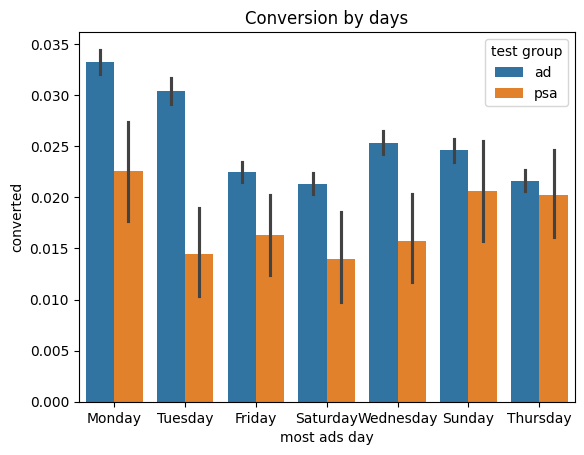

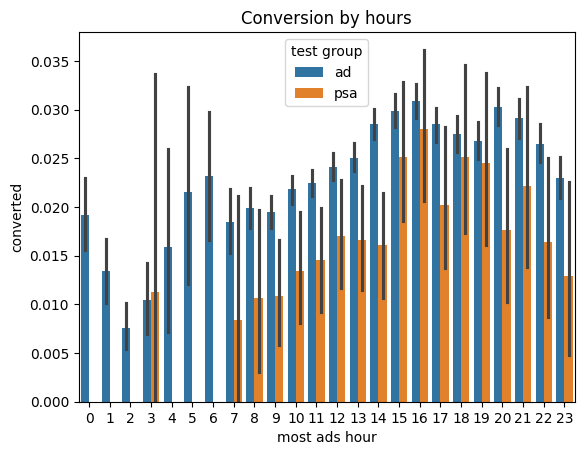

In [49]:
# Visualize the relation of most ads hour and most ads day with converted variable.
plt.figsize=(8, 5)
sns.barplot(data=df, x='most ads day', y='converted', hue='test group')
plt.title('Conversion by days')
plt.show()

plt.figsize=(10, 6)
sns.barplot(data=df, x='most ads hour', y='converted', hue='test group')
plt.title('Conversion by hours')
plt.show()

### Check the relation of Converted and reference_time

In [50]:
# Define  a function to categorize hours into morning, evening, and night
def hour_cat(hour):
    if hour in range(5, 12):
        return 'morning'
    elif hour in range(12, 17):
        return 'afternoon'
    elif hour in range(17, 21):
        return 'evening'
    else:
        return 'night'
    
df['time_reference'] = df['most ads hour'].apply(hour_cat)

In [51]:
df['time_reference'].value_counts()

time_reference
afternoon    222851
morning      143018
evening      126586
night         95646
Name: count, dtype: int64

In [52]:
df.groupby('time_reference')['converted'].sum().reset_index(name='total_converted')

,time_reference,total_converted
0,afternoon,6065
1,evening,3545
2,morning,2977
3,night,2256


`Null Hypothesis:`There is no significant association between the two variables.

`Alternate Hypothesis:` There is a significant association between the two variables.

In [53]:
# make a contingency table
contingency_table = pd.crosstab(df['converted'], df['time_reference'])
print(contingency_table)
print("-"*50)
# perfor chi2 test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"chi2: {chi2}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}")


time_reference  afternoon  evening  morning  night
converted                                         
0                  216786   123041   140041  93390
1                    6065     3545     2977   2256
--------------------------------------------------
chi2: 199.10145345082745
p-value: 6.596461961915452e-43
degrees of freedom: 3


 -  Now we can clealy understand that the people who watch ads in afternoon are more likely to convert than those who watch ads in morning and evening times.

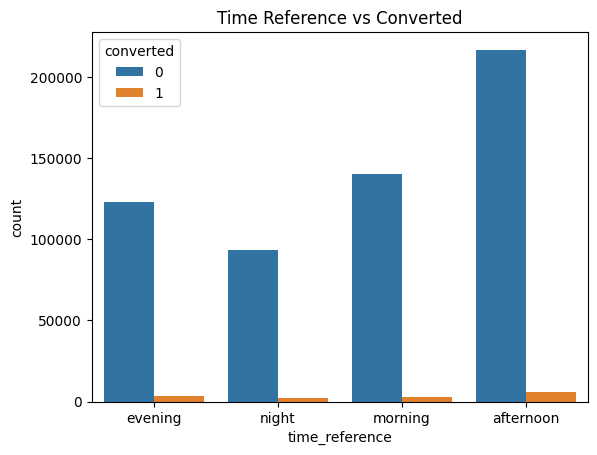

In [54]:
# visualize the relation of converted and most ads hour.
sns.countplot(data=df, x='time_reference', hue='converted')
plt.title('Time Reference vs Converted')
plt.show()

## Ad Stauration Impact

In [55]:
# Assess how the number of ads viewed (total_ads) affects conversion likelihood.
# Bin total_ads into ranges and calculate the conversion rate for each range.

# Bin total_ads into ranges
bins = [0, 100, 500, np.inf] # It represents infinity and is used to include all values greater than 500. 
labels = ['low', 'medium', 'high']
df['total_ads_range'] = pd.cut(df['total ads'], bins=bins, labels=labels)

# Calculate conversion rate for each bin
conversion_rates_by_bins = df.groupby('total_ads_range')['converted'].mean()
print(conversion_rates_by_bins)

total_ads_range
low       0.019369
medium    0.168958
high      0.172650
Name: converted, dtype: float64


C:\Users\X\AppData\Local\Temp\ipykernel_10352\2256962026.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates_by_bins = df.groupby('total_ads_range')['converted'].mean()


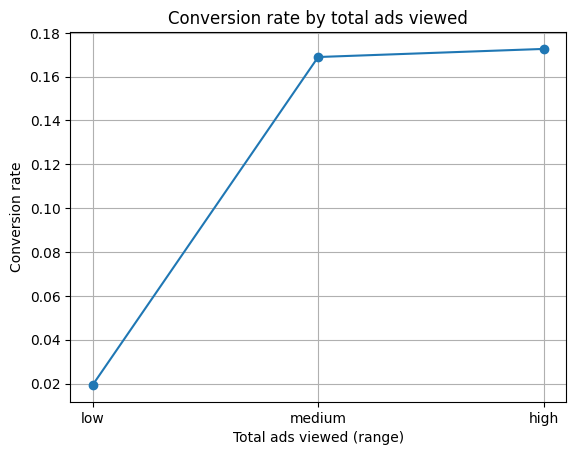

In [56]:
#Now visualize this relationship between total_ads_range and converted
plt.figsize=(12,6)
plt.plot(conversion_rates_by_bins.index, conversion_rates_by_bins.values, marker='o')
plt.xlabel('Total ads viewed (range)')
plt.ylabel('Conversion rate')
plt.title('Conversion rate by total ads viewed')
plt.grid(True)
plt.show()

### Perform Chi-Squared Test for total_ads_range and converted

In [57]:
#make a contingency table
contingency_table_range = pd.crosstab(df['converted'], df['total_ads_range'])
print(contingency_table_range)

total_ads_range     low  medium  high
converted                            
0                554093   18681   484
1                 10944    3798   101


In [58]:
# perform chi2 test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_range)
print(f"chi2: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"degrees of freedom: {dof}")

alpha = 0.05
if p_value < alpha:
    print('There is a statistically significant relationship between total ads viewed and conversion rate')
else:
    print('There is no statistically significant relationship between total ads viewed and conversion rate')

chi2: 20180.949380737515
p-value: 0.0
degrees of freedom: 2
There is a statistically significant relationship between total ads viewed and conversion rate


> these two variable are associated with each other.

### Levene's Test for Homogeneity of variance

Levene's Test is a statistical procedure used to assess the equality of variances across multiple groups. This is known as the homogeneity of variance.

In [59]:
from scipy.stats import levene

`Null Hypothesis`: Variances are equal between the two groups

 `Alternative Hypothesis`: Variances are not equal between the two groups

In [60]:
# Separate the 'time' data into two groups based on the 'converted' column
groupN = df[df['converted']== False]['total ads']
groupY = df[df['converted']== True]['total ads']

# Perform the Levene test
stat, p = levene(groupN, groupY)

print(f"Levene test statistic: {stat}")
print(f"p-value: {p}")

Levene test statistic: 9121.196956737573
p-value: 0.0


 - High F-statistic: Indicates significant differences in variances among groups.
 - Low F-statistic: Suggests that the variances are similar across groups.

 - This means that the variances of total ads between users who converted and those who did not are significantly different, implying unequal spread of the data in each group.

### t-test for Independent Samples

In [61]:
from scipy.stats import ttest_ind

A t-test is a statistical test used to determine if there is a significant difference between the means of two groups. It is particularly useful when the sample sizes are small and the population standard deviation is unknown.

>Independent Samples T-Test: Compares the means of two independent groups (e.g., comparing test scores between two different classes)

`Null hypothesis`: There is not any difference in means of two groups

`Alternative hypothesis`: There is a difference in means of two groups

In [62]:
# Separate the data into two groups based on the 'converted' column
groupN = df[df['converted'] == False]['total ads']
groupY = df[df['converted'] == True]['total ads']

# perform t-test for two samples
stat, p = ttest_ind(groupN, groupY, equal_var=False)

print(f"t-test statistic: {stat}")
print(f"p-value: {p}")

t-test statistic: -84.17740664633055
p-value: 0.0


 - The p-value is also less than `0.05`, so we reject the null hypothesis. This means there is a statistically significant difference in the means of total ads seen between the converted and non-converted groups.

 - Since the t-statistic is negative, it indicates that the mean number of ads seen by the non-converted group is higher than the mean for the converted group.

**Conclusion:**¶

- The variances between the two groups are not homogeneous, as indicated by Levene's test.
- There is a significant difference in the means of total ads seen between the groups. On average, users who did not convert saw more ads than those who converted.


- This suggests that exposing users to more ads does not necessarily increase the likelihood of conversion, and there might be an optimal threshold of ad exposure beyond which users do not engage further.

## Audience Segmentation

In [63]:
from sklearn.cluster import KMeans

In [64]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,time_reference,total_ads_range
0,0,1069124,ad,0,130,Monday,20,evening,medium
1,1,1119715,ad,0,93,Tuesday,22,night,low
2,2,1144181,ad,0,21,Tuesday,18,evening,low
3,3,1435133,ad,0,355,Tuesday,10,morning,medium
4,4,1015700,ad,0,276,Friday,14,afternoon,medium


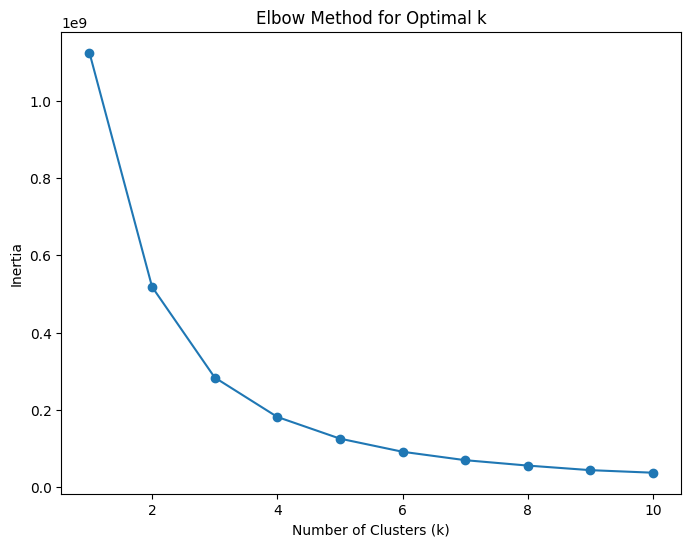

In [65]:
# Cluster users based on total_ads, most_ads_day, and most_ads_hour.
# Feature selection for clustering
features = ['total ads', 'most ads day', 'most ads hour']
X = df[features]

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['most ads day', 'most ads hour'], drop_first=True)

# Determine optimal number of clusters (e.g., using the Elbow method)
inertia = []
for k in range(1, 11):  # Test clusters from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

- The Elbow method is a technique used to determine the optimal number of clusters when using the KMeans clustering algorithm. Here's how it works in this code:

- Inertia Calculation: The code iterates through a range of potential cluster numbers (from 1 to 10 in this case). For each cluster number (k), it:
  - Initializes a KMeans model with k clusters.
  - Fits the model to the data (X).
  - Calculates the inertia and stores it in a list called inertia.
  - `Inertia` represents the sum of squared distances of samples to their closest cluster center.  Lower inertia generally indicates better clustering, but using too many clusters can lead to overfitting.

- Finding the Elbow: This plot typically shows a curve that decreases sharply at first and then gradually levels off. The "elbow" point, where the rate of decrease in inertia starts to slow down, is often considered the optimal number of clusters. The user visually inspects the plot to identify this elbow point and then sets the optimal_k variable accordingly.

cluster
0    0.012026
1    0.154711
2    0.139509
Name: converted, dtype: float64


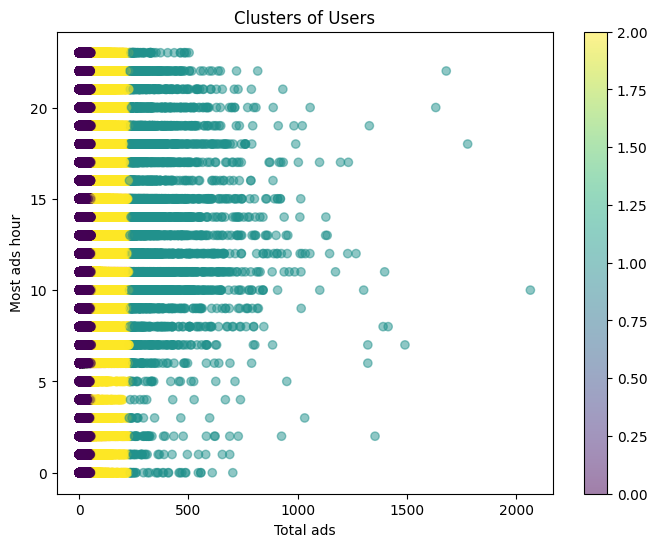

In [66]:
# Investigate conversion rates within these clusters to find high-performing segments.
# Apply KMeans clustering with the chosen number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Calculate conversion rates within each cluster
conversion_rates_by_cluster = df.groupby('cluster')['converted'].mean()
print(conversion_rates_by_cluster)

#Visualize the conversion rates within each cluster
plt.figure(figsize=(8, 6))
plt.scatter(df['total ads'], df['most ads hour'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Total ads')
plt.ylabel('Most ads hour')
plt.title('Clusters of Users')
plt.colorbar()
plt.show()

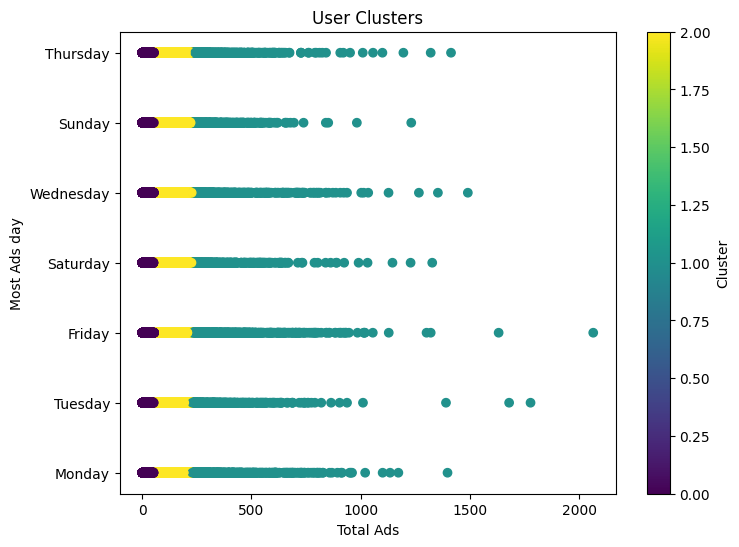

In [67]:
# Visualize clusters (with two features)
plt.figure(figsize=(8, 6))
plt.scatter(df['total ads'], df['most ads day'], c=df['cluster'], cmap='viridis')
plt.xlabel('Total Ads')
plt.ylabel('Most Ads day')
plt.title('User Clusters')
plt.colorbar(label='Cluster')
plt.show()

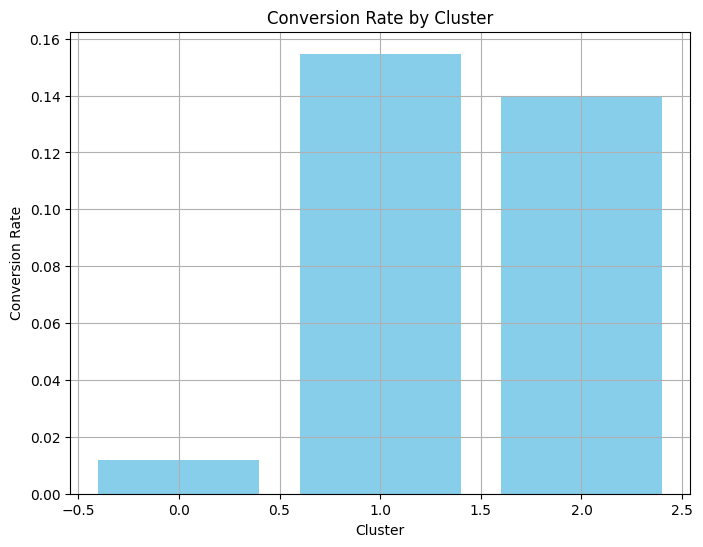

In [68]:
#Visualize the conversion rates within each cluster
plt.figure(figsize=(8, 6))
plt.bar(conversion_rates_by_cluster.index, conversion_rates_by_cluster.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Cluster')
plt.grid(True)
plt.show()

## Peak Ad Performance

In [69]:
# Aggregate 'most_ads_hour' data to identify peak hours
peak_hours = df['most ads hour'].value_counts().sort_values(ascending=False)
print("\nPeak hours across all users:\n", peak_hours)


Peak hours across all users:
 most ads hour
13    47655
12    47298
11    46210
14    45648
15    44683
10    38939
16    37567
17    34988
18    32323
9     31004
19    30352
21    29976
20    28923
22    26432
23    20166
8     17627
7      6405
0      5536
2      5333
1      4802
3      2679
6      2068
5       765
4       722
Name: count, dtype: int64


In [70]:
# Cross-check peak hours with conversion data
peak_hour_conversions = df.groupby('most ads hour')['converted'].mean()
print("\nConversion rates during peak hours:\n", peak_hour_conversions)


Conversion rates during peak hours:
 most ads hour
0     0.018425
1     0.012911
2     0.007313
3     0.010452
4     0.015235
5     0.020915
6     0.022244
7     0.018111
8     0.019516
9     0.019191
10    0.021521
11    0.022116
12    0.023828
13    0.024677
14    0.028063
15    0.029653
16    0.030772
17    0.028210
18    0.027380
19    0.026720
20    0.029803
21    0.028923
22    0.026105
23    0.022662
Name: converted, dtype: float64


In [71]:
# Combine peak hours and conversion rates for analysis
peak_performance = pd.DataFrame({'Peak_Hours': peak_hours.index, 'Ad_Count': peak_hours.values, 'Conversion_Rate': peak_hour_conversions.values})
print("\nPeak Ad Performance:\n", peak_performance)


Peak Ad Performance:
     Peak_Hours  Ad_Count  Conversion_Rate
0           13     47655         0.018425
1           12     47298         0.012911
2           11     46210         0.007313
3           14     45648         0.010452
4           15     44683         0.015235
5           10     38939         0.020915
6           16     37567         0.022244
7           17     34988         0.018111
8           18     32323         0.019516
9            9     31004         0.019191
10          19     30352         0.021521
11          21     29976         0.022116
12          20     28923         0.023828
13          22     26432         0.024677
14          23     20166         0.028063
15           8     17627         0.029653
16           7      6405         0.030772
17           0      5536         0.028210
18           2      5333         0.027380
19           1      4802         0.026720
20           3      2679         0.029803
21           6      2068         0.028923
22         

- Overall, this peak_performance dataframe provides us insights on best performing time for ads, peak engagement time, and  peak hours with conversion data to find high-ROI ad placement times.

## The equality of proportions hypothesis

In [72]:
cross_tab = pd.crosstab(df['test group'], df['converted'], normalize='index')
cross_tab

converted,0,1
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


##### Define the null and alternative hypothsis

`Null Hypothesis (H₀)`: there is no difference in the conversion rates between the test group

`Alternative Hypothesis` : there is a difference in the conversion rates between the test group and the control group

Set the probability of type I and type II errors

- α=0.05 

- β=0.2

##### Calculate the sample size

Based on the provided conversion data, we have the conversion rates for two groups in an A/B test: one group that saw the advertisement ("ad") and another that saw a public service announcement ("psa"). The conversion rates are calculated as follows:

**Ad Group**:

 - Conversion Rate: 2.55% (0.025547)

**PSA Group**:

 - Conversion Rate: 1.79% (0.017854) To determine the sample size needed for such an A/B test, you can use these conversion rates as your baseline rates (p1 and p2). Here's how you can proceed: Steps to Determine Sample Size

**Define Parameters**:

1. Baseline Conversion Rate (p1): Use the conversion rate of the PSA group, which is 1.79%.
2. Expected Conversion Rate (p2): Use the conversion rate of the Ad group, which is 2.55%.
3. Significance Level (α): Typically set at 0.05.
4. Power (1-β): Typically set at 0.8 (80%).

In [73]:
from statsmodels.stats.power import NormalIndPower

`NormalIndPower` is a class in the statsmodels library in Python that is used for power analysis in the context of comparing two independent groups. Power analysis is a statistical method used to determine the likelihood that a study will detect an effect of a given size, assuming that the effect actually exists in the population.

1. `Power`: The power of a statistical test is the probability that it will correctly reject a false null hypothesis (i.e., detect an effect when there is one). It is typically denoted as (1 - \beta), where (\beta) is the probability of making a Type II error (failing to reject a false null hypothesis). A common target for power is 0.80, meaning there is an 80% chance of detecting an effect if it exists.

2. `Effect Size`:  A quantitative measure of the magnitude of the effect or difference that the study aims to detect. Larger effect sizes generally require smaller sample sizes to achieve the same power.

3. `Sample Size`: The number of observations or data points collected for each group in the study. A larger sample size generally increases the power of the test.

4. `Significance Level (alpha)`: This is the threshold for rejecting the null hypothesis, commonly set at 0.05. It represents the probability of making a Type I error (rejecting a true null hypothesis).

In [74]:
# parameters
alpha = 0.05
power = 0.8
p1 = 0.017854
p2 = 0.025547

#calculate the average conversion rate
p = (p1 + p2) / 2

# calculate the effect size
effect_size = (p2 - p1) / ((p * (1 - p)) ** 0.5)

# calculate the sample size per group
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)

print(f"Requireed sample size: {int(sample_size)}")

Requireed sample size: 5631


# Generate a Sample from df

In [75]:
# define a function to choose random sample
def random_sample(data, random_state=42):
    return data.sample(int(sample_size), random_state=random_state)

# Apply the function to each group using groupby func.
df_smpl = df.groupby('test group', group_keys=False).apply(random_sample)

C:\Users\X\AppData\Local\Temp\ipykernel_10352\1131861444.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smpl = df.groupby('test group', group_keys=False).apply(random_sample)


In [76]:
df_smpl

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,time_reference,total_ads_range,cluster
529666,529666,1300427,ad,0,21,Friday,20,evening,low,0
385537,385537,1197483,ad,0,2,Thursday,20,evening,low,0
120467,120467,1234257,ad,0,20,Sunday,10,morning,low,0
186608,186608,1384841,ad,1,47,Friday,14,afternoon,low,0
141292,141292,1646962,ad,0,13,Tuesday,13,afternoon,low,0
...,...,...,...,...,...,...,...,...,...,...
158646,158646,909937,psa,0,7,Thursday,12,afternoon,low,0
521629,521629,903824,psa,0,6,Thursday,20,evening,low,0
376798,376798,920768,psa,0,7,Wednesday,19,evening,low,0
282973,282973,908849,psa,0,12,Monday,13,afternoon,low,0


In [77]:
import plotly.express as px
import plotly.graph_objects as go

In [78]:
# Assuming df_smpl is your DataFrame
fig = px.histogram(df_smpl, x='test group', color='converted', barmode='group')

# Show the figure
fig.show()

In [85]:
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

In [86]:
# Create the contingency table for Z-test
contingency_table_Z = pd.crosstab(df_smpl['test group'], df_smpl['converted'])
print("\nContingency Table for Z-Test:")
print(contingency_table_Z)


Contingency Table for Z-Test:
converted      0    1
test group           
ad          5481  150
psa         5524  107


In [88]:
# Count the successes and trials for each group
success_ad = contingency_table_Z.loc['ad', 1] if 'ad' in contingency_table_Z.index else 0
trials_ad = contingency_table_Z.loc['ad', 0] + contingency_table_Z.loc['ad', 1] if 'ad' in contingency_table_Z.index else 0

success_psa = contingency_table_Z.loc['psa', 1] if 'psa' in contingency_table_Z.index else 0
trials_psa = contingency_table_Z.loc['psa', 0] + contingency_table_Z.loc['psa', 1] if 'psa' in contingency_table_Z.index else 0

In [89]:
# Perform Z-test for proportions
if trials_ad > 0 and trials_psa > 0:
    z_stat, p_value = sm.stats.proportions_ztest([success_ad, success_psa], [trials_ad, trials_psa], alternative='two-sided')

    # Display Z-statistic and p-value
    print(f"\nZ-statistic: {z_stat}")
    print(f"P-value: {p_value}")

    # Hypothesis conclusion
    if p_value < alpha:
        print("\nReject the null hypothesis. There is a significant difference in proportions.")
    else:
        print("\nFail to reject the null hypothesis. Proportions are not significantly different.")
else:
    print("\nOne or both groups have zero trials or conversions. Z-test cannot be performed.")


Z-statistic: 2.7134050689178086
P-value: 0.006659564617241406

Reject the null hypothesis. There is a significant difference in proportions.


- Checking for the equality of proportions is essential in various scenarios to understand if there are significant differences between groups or categories regarding a particular characteristic or outcome.